In [1]:
import requests
import os
import tarfile

In [2]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def download_file(url, target_path):
    # Verificar y crear directorio si es necesario
    ensure_dir(target_path)
    # Descargar el archivo desde `url` y guardar en `target_path`
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            for chunk in response.iter_content(4096):
                f.write(chunk)
    print(f"Descargado: {target_path}")

def untar_file(tar_path):
    # Abrir el archivo TAR y extraer su contenido
    extract_to = os.path.dirname(tar_path)
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(extract_to)
    print(f"Descomprimido: {tar_path}")

In [3]:
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
target_path = 'datasets/PascalVOC2012/VOCtrainval_11-May-2012.tar'

download_file(url, target_path)
untar_file(target_path)

Descargado: datasets/PascalVOC2012/VOCtrainval_11-May-2012.tar
Descomprimido: datasets/PascalVOC2012/VOCtrainval_11-May-2012.tar


In [19]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

In [20]:
def xml_to_dataframe(annotations_path):
    records = []
    for annotation_file in os.listdir(annotations_path):
        if annotation_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_path, annotation_file))
            root = tree.getroot()
            
            file_name = root.find('filename').text
            width = int(float(root.find('.//size/width').text))
            height = int(float(root.find('.//size/height').text))
            
            for obj in root.findall('object'):
                category = obj.find('name').text
                xmin = int(float(obj.find('./bndbox/xmin').text))
                ymin = int(float(obj.find('./bndbox/ymin').text))
                xmax = int(float(obj.find('./bndbox/xmax').text))
                ymax = int(float(obj.find('./bndbox/ymax').text))
                
                records.append({
                    'file_name': file_name,
                    'width': width,
                    'height': height,
                    'category_name': category,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                })
                
    return pd.DataFrame(records)

# Llamada a la función asumiendo la ruta al directorio de anotaciones XML
annotations_path = 'datasets/PascalVOC2012/VOCdevkit/VOC2012/Annotations'
df_annotations = xml_to_dataframe(annotations_path)
df_annotations.head()

,file_name,width,height,category_name,xmin,ymin,xmax,ymax
0,2009_001472.jpg,500,375,bus,30,48,460,331
1,2009_001472.jpg,500,375,car,448,208,496,240
2,2009_001472.jpg,500,375,bus,1,162,37,221
3,2009_001137.jpg,500,334,person,187,121,355,334
4,2009_001137.jpg,500,334,pottedplant,376,1,500,261


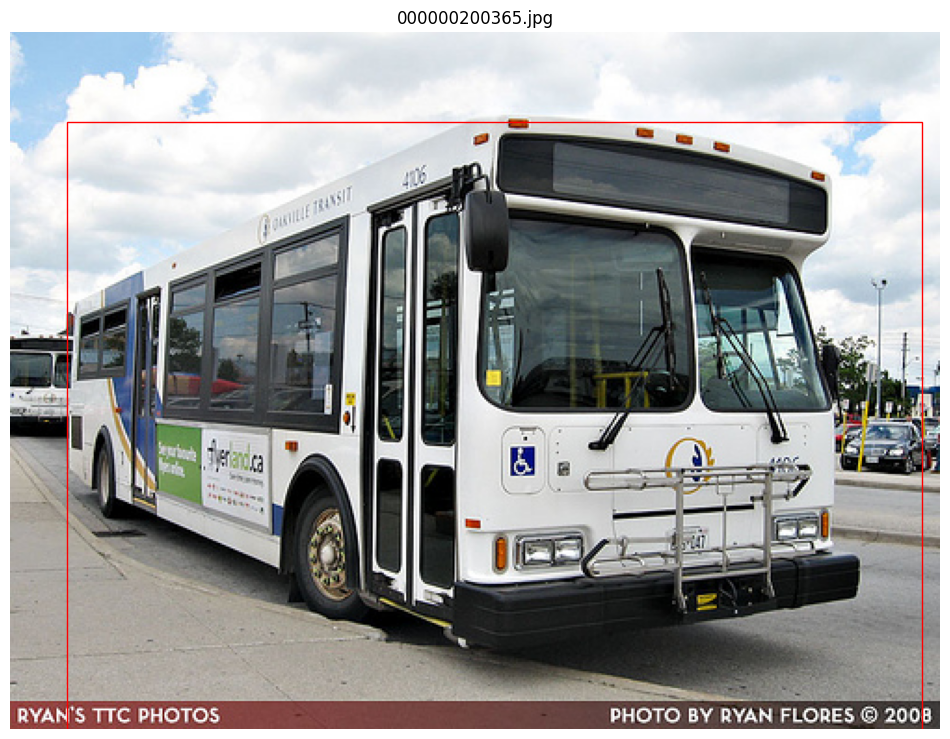

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread

def plot_image_with_annotations(path, filename, rectangles=None, segmentations=None, figsize=(10, 8), title=None):
    """
    Carga y muestra una imagen usando solo Matplotlib, dibujando rectángulos y segmentaciones definidas por el usuario.
    
    Parámetros:
    - path (str): El camino hacia el directorio donde se encuentra la imagen.
    - filename (str): El nombre del archivo de la imagen.
    - rectangles (list of tuples): Lista de tuplas (x, y, w, h) para dibujar rectángulos en la imagen.
    - segmentations (list of list of floats): Lista que contiene puntos de contorno intercalados [x1, y1, x2, y2, ...].
    - figsize (tuple): Tamaño de la figura (opcional).
    - title (str): Título de la imagen (opcional).
    """
    # Construye la ruta completa de la imagen
    full_path = f"{path}/{filename}"
    
    # Carga la imagen con Matplotlib
    img = imread(full_path)
    
    # Crea la figura y el eje
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis('off')  # Desactiva los ejes
    
    # Dibuja los rectángulos si se proporcionaron
    if rectangles:
        for (x, y, w, h) in rectangles:
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
    # Dibuja los contornos de segmentación si se proporcionaron
    if segmentations:
        for seg in segmentations:
            # Transforma la lista plana en una lista de tuplas (x, y)
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            x, y = zip(*points)  # Desempaqueta la lista de tuplas
            ax.plot(x, y, 'b-', linewidth=1)  # Dibuja el contorno
    
    # Configura el título, si se proporcionó
    if title:
        ax.set_title(title)
    
    # Muestra la imagen
    plt.show()

plot_image_with_annotations('datasets/PascalVOC2012/VOCdevkit/VOC2012/JPEGImages', '2009_001472.jpg',
                            rectangles=[[30, 48, 460, 331]],
                            figsize=(12, 10),
                            title='000000200365.jpg')

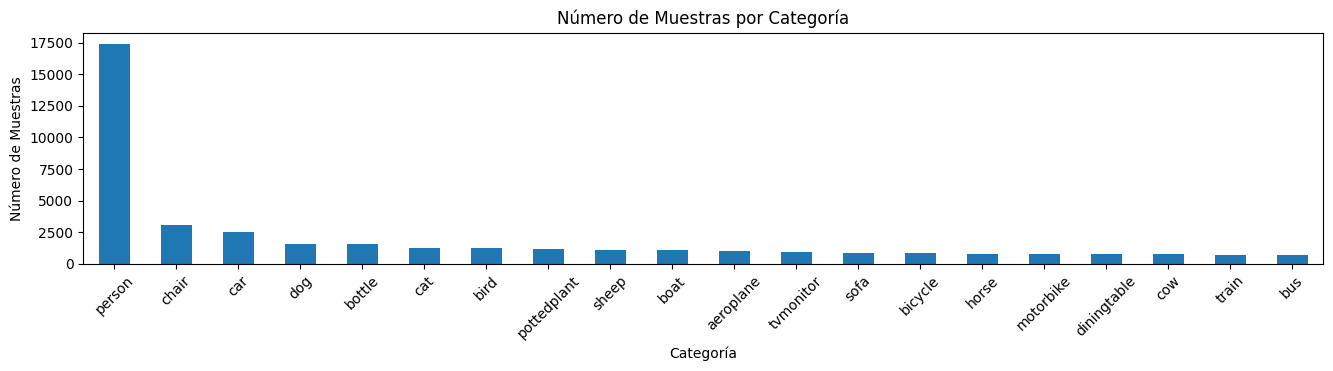

In [23]:
# Crear un gráfico de barras
plt.figure(figsize=(16, 3))  # Ajusta el tamaño del gráfico según necesites
df_annotations['category_name'].value_counts().plot(kind='bar')
plt.title('Número de Muestras por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=45)  # Rota las etiquetas para mejor legibilidad
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random

def plot_random_images_by_category(df, category_name, image_folder_path, num_images=5):
    """
    Muestra imágenes aleatorias de una categoría específica en un DataFrame.
    
    Parámetros:
    - df (DataFrame): DataFrame que contiene los metadatos de las imágenes.
    - category_name (str): Nombre de la categoría para filtrar las imágenes.
    - image_folder_path (str): Ruta del directorio donde se almacenan las imágenes.
    - num_images (int): Número de imágenes aleatorias a mostrar.
    """
    # Filtrar el DataFrame por la categoría deseada
    filtered_df = df[df['category_name'] == category_name]
    
    # Seleccionar aleatoriamente 'num_images' entradas
    if len(filtered_df) > num_images:
        sampled_df = filtered_df.sample(n=num_images)
    else:
        sampled_df = filtered_df
    
    # Configurar la figura para mostrar las imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
    for ax, (_, row) in zip(axes, sampled_df.iterrows()):
        # Construir la ruta completa de la imagen
        image_path = os.path.join(image_folder_path, row['file_name'])
        
        # Cargar y mostrar la imagen
        image = imread(image_path)
        ax.imshow(image)
        ax.axis('off')  # Ocultar los ejes
        ax.set_title(f'{category_name}')
    
    plt.tight_layout()
    plt.show()

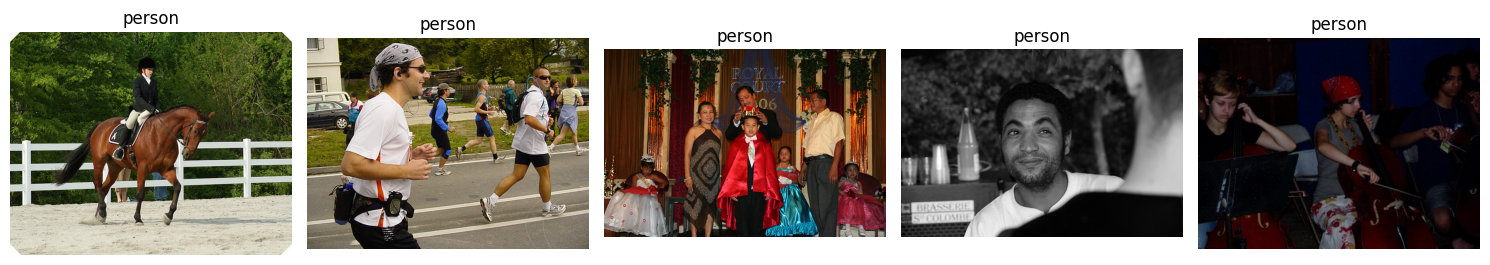

In [27]:
# Ejemplo de uso
category_to_display = 'person'  # Cambia esto por la categoría que desees
image_folder = 'datasets/PascalVOC2012/VOCdevkit/VOC2012/JPEGImages'
plot_random_images_by_category(df_annotations, category_to_display, image_folder)

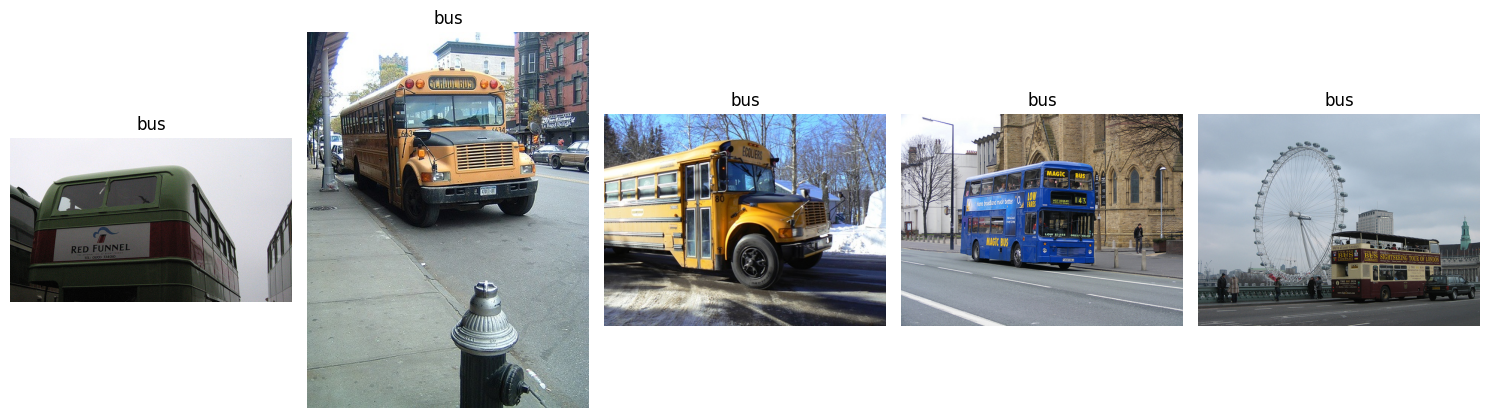

In [29]:
category_to_display = 'bus'  # Cambia esto por la categoría que desees
image_folder = 'datasets/PascalVOC2012/VOCdevkit/VOC2012/JPEGImages'
plot_random_images_by_category(df_annotations, category_to_display, image_folder)

In [31]:
def load_image_set(filename):
    with open(filename, 'r') as file:
        return [line.strip() for line in file.readlines()]

# Rutas a los archivos
base_dir = 'datasets/PascalVOC2012/VOCdevkit/VOC2012/ImageSets/Main'
train_ids = load_image_set(os.path.join(base_dir, 'train.txt'))
val_ids = load_image_set(os.path.join(base_dir, 'val.txt'))

print("Train IDs:", len(train_ids))
print("Validation IDs:", len(val_ids))


Train IDs: 5717
Validation IDs: 5823


In [ ]:
import os

def load_annotations(image_ids, annotations_path, images_path):
    data = []
    for image_id in image_ids:
        xml_file = os.path.join(annotations_path, f"{image_id}.xml")
        image_file = os.path.join(images_path, f"{image_id}.jpg")
        annotations = parse_annotation(xml_file)  # Asume que ya tienes esta función definida
        data.append({'image_id': image_id, 'annotations': annotations, 'image_path': image_file})
    return data

# Uso de ejemplo
annotations_path = 'VOCdevkit/VOC2012/Annotations'
images_path = 'VOCdevkit/VOC2012/JPEGImages'
train_data = load_annotations(train_ids, annotations_path, images_path)